In [1]:
import numpy as np
import random
from functools import reduce
import matplotlib.pyplot as plt
n_qubits = 10
n_layers=1
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Rotation gate around Y-axis
def RY(theta):
    return np.array([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2),  np.cos(theta/2)]
    ])

#Tensor product 
def kron_n(*ops):
    return reduce(np.kron, ops)
#initial state |000...0⟩
def initial_state(n):
    state = np.zeros(2**n, dtype=complex)
    state[0] = 1.0
    return state
#Construct full CNOT
def get_cnot_matrix(n_qubits, control, target):
    P0 = np.array([[1, 0], [0, 0]])  # |0⟩⟨0|
    P1 = np.array([[0, 0], [0, 1]])  # |1⟩⟨1|
    
    ops_0 = []
    ops_1 = []
    
    for i in range(n_qubits):
        if i == control:
            ops_0.append(P0)
            ops_1.append(P1)
        elif i == target:
            ops_0.append(I)
            ops_1.append(X)
        else:
            ops_0.append(I)
            ops_1.append(I)
    
    term1 = kron_n(*ops_0)
    term2 = kron_n(*ops_1)
    return term1 + term2
#Apply single-qubit gate
def apply_single_qubit_gate(state, gate, target, n_qubits):
    ops = [I] * n_qubits
    ops[target] = gate
    U = kron_n(*ops)
    return U @ state
#Applying CNOT
def apply_cnot(state, control, target, n_qubits):
    U_cnot = get_cnot_matrix(n_qubits, control, target)
    return U_cnot @ state
def hamiltonian(n_qubits, edges, seed):
    np.random.seed(seed)
    weights = np.random.uniform(0.2, 0.8, len(edges))
    
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)

    for (idx, (i, j)) in enumerate(edges):
        ops = [I] * n_qubits
        ops[i] = Z
        ops[j] = Z
        term = weights[idx] * kron_n(*ops)
        H += term

    return H, weights
def print_symbolic_hamiltonian(edges, weights):
    print("H = ", end="")
    terms = []
    for (i, j), w in zip(edges, weights):
        terms.append(f"{w:.3f} * Z[{i}]Z[{j}]")
    print(" + ".join(terms))
def ansatz(theta, n_qubits, edges, n_layers):
    state = initial_state(n_qubits)
    param_idx = 0

    for _ in range(n_layers):
        # Apply RY rotation to each qubit
        for i in range(n_qubits):
            angle = theta[param_idx]
            param_idx += 1
            ry_gate = RY(angle)
            state = apply_single_qubit_gate(state, ry_gate, i, n_qubits)

        # Apply CNOTs based on Hamiltonian structure
        for control, target in edges:
            state = apply_cnot(state, control, target, n_qubits)
    state = state / np.linalg.norm(state)
    return state

def generate_random_edges(n_qubits, n_edges, seed):
    random.seed(seed)
    all_possible_edges = [(i, j) for i in range(n_qubits) for j in range(i + 1, n_qubits)]
    edges = random.sample(all_possible_edges, min(n_edges, len(all_possible_edges)))
    return edges




In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_qubit_connectivity(n_qubits, edges,seed):
    G = nx.Graph()
    G.add_nodes_from(range(n_qubits))
    G.add_edges_from(edges)

    pos = nx.spring_layout(G, seed)  # Force-directed layout
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', edge_color='gray', width=2)
    plt.title("Qubit Connectivity Graph (Based on Hamiltonian Edges)")
    plt.show()



Edges: [(6, 8), (0, 8), (0, 2), (2, 3), (1, 8), (1, 7), (0, 9), (0, 7), (4, 9), (0, 6), (3, 7), (0, 3), (7, 8), (5, 6), (5, 8)]


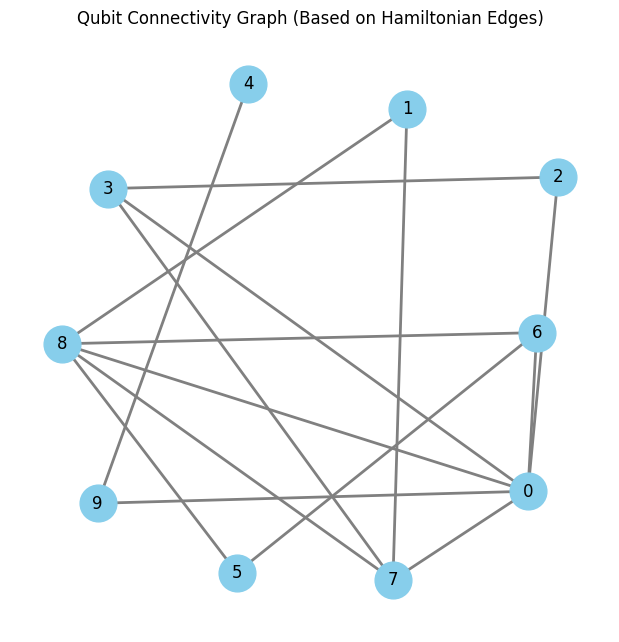

In [3]:
n_qubits = 10
n_edges = 15
seed = 42   
n_layers = 2
pdim=n_layers*n_qubits
edges = generate_random_edges(n_qubits, n_edges, seed)
print ("Edges:", edges)
visualize_qubit_connectivity(n_qubits, edges,seed)


In [4]:
def expectation(theta, H, n_qubits, n_layers):
    psi = ansatz(theta, n_qubits,edges, n_layers)
    return np.real(np.vdot(psi, H @ psi))
H, weights = hamiltonian(n_qubits, edges, seed)
print_symbolic_hamiltonian(edges, weights)
def cost(theta):
    return expectation(theta, H, n_qubits,n_layers)


H = 0.425 * Z[6]Z[8] + 0.770 * Z[0]Z[8] + 0.639 * Z[0]Z[2] + 0.559 * Z[2]Z[3] + 0.294 * Z[1]Z[8] + 0.294 * Z[1]Z[7] + 0.235 * Z[0]Z[9] + 0.720 * Z[0]Z[7] + 0.561 * Z[4]Z[9] + 0.625 * Z[0]Z[6] + 0.212 * Z[3]Z[7] + 0.782 * Z[0]Z[3] + 0.699 * Z[7]Z[8] + 0.327 * Z[5]Z[6] + 0.309 * Z[5]Z[8]


In [46]:
#Optimising using Nelder-Mead algorithm
def nelder_mead(f, x_start, step=0.5, tol=1e-6, max_iter=500):
    n = len(x_start)
    # Initialize simplex
    f_history = []
    simplex = [x_start]
    for i in range(n):
        x = np.array(x_start, dtype=float)
        x[i] += step
        simplex.append(x)
    simplex = np.array(simplex)
    #$print(simplex)
    for iteration in range(max_iter):
        # Sort simplex points by function value
        simplex = sorted(simplex, key=f)
        f_values = [f(x) for x in simplex]

        # Check convergence
        if np.std(f_values) < tol:
            break

        # Compute centroid (excluding worst point)
        centroid = np.mean(simplex[:-1], axis=0)

        # Reflection
        xr = centroid + (centroid - simplex[-1])
        fr = f(xr)

        if f_values[0] <= fr < f_values[-2]:
            simplex[-1] = xr
        elif fr < f_values[0]:
            # Expansion
            xe = centroid + 2 * (xr - centroid)
            fe = f(xe)
            simplex[-1] = xe if fe < fr else xr
        else:
            # Contraction
            xc1 = simplex[-1] + 0.25 * (xr-simplex[-1] )   
            xc3 = simplex[-1] + 0.75 * (xr-simplex[-1] )
            fc1 = f(xc1)
            fc3 = f(xc3)
            xc = 0
            fc = 0
            if fc1 < fc3:
                xc,fc= xc1,fc1
            else:
                xc,fc = xc3,fc3
            if fc < f_values[-1]:
                simplex[-1] = xc1
            else:
                # Shrink
                for i in range(1, len(simplex)):
                    simplex[i] = simplex[0] + 0.5 * (simplex[i] - simplex[0])
        f_history.append(f_values[0])
    best = min(simplex, key=f)
    return best, f(best), iteration + 1,f_history


x0 = np.random.uniform(0, 2 * np.pi,pdim)  # Initial guess
solnm, fval, iters,fhisto = nelder_mead(cost, x0)
print("[Nelder-Mead] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:", fval)
print("[Nelder-Mead] Optimal θ:", solnm)
print("[Nelder-Mead] Iterations:", iters)


[Nelder-Mead] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: -3.2963315847559564
[Nelder-Mead] Optimal θ: [ 3.05899811  5.4129099   4.57725224  1.46457726 -0.25596379  1.0308075
  1.30474114  5.06878101  4.74549769  4.95673827 -0.02230638  6.78747495
  4.48242045 -1.02882366  2.66532569  2.24461484  1.77448083  2.65951361
  4.58656751  1.87606572]
[Nelder-Mead] Iterations: 500


In [48]:
solnm = np.array(solnm)

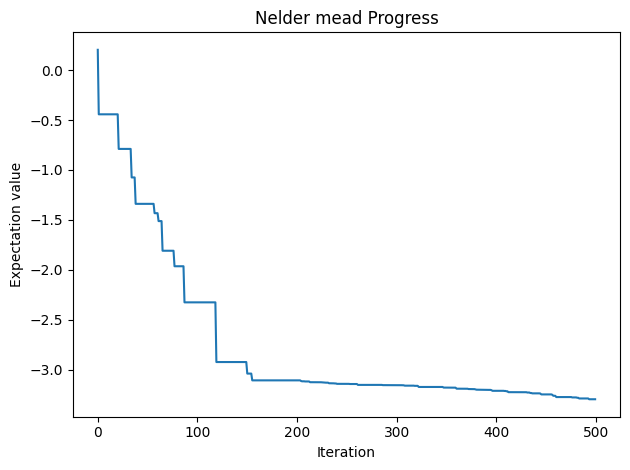

In [47]:
plt.plot(fhisto)
plt.xlabel('Iteration')
plt.ylabel('Expectation value')
plt.title('Nelder mead Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [23]:
# Optimising using SPSA algorithm
a = 0.7
c = 0.1
A = 80
alpha = 0.602
gamma = 0.101
f_history = []

# Initial point
#theta =np.random.uniform(0, 3*np.pi, size=(n_layers*n_qubits))
theta=np.random.uniform(0, 2 * np.pi, n_qubits*n_layers)
max_iterations = 1000
tolerance = 1e-6
np.random.seed(42)

for k in range(max_iterations):
    ak = a / (A + k + 1)**alpha
    ck = c / (k + 1)**gamma
    delta = np.random.choice([-1, 1], size=pdim)  #perturbation vector Δ_k from Bernoulli(±1)
    theta_plus = theta + ck * delta
    theta_minus = theta - ck * delta
    y_plus = cost(theta_plus)
    y_minus = cost(theta_minus)
    g_hat = (y_plus - y_minus) / (2 * ck) * (1.0 / delta)
    theta = theta - ak * g_hat
    f_val = cost(theta)
    f_history.append(f_val)
    if k > 1 and abs(f_history[-1] - f_history[-2]) < tolerance and abs(f_history[-2] - f_history[-3]) < tolerance:
        break
print("[SPSA] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:", f_val)
print("[SPSA] Optimal θ:", theta)
solspsa = theta
print("[SPSA] Iterations:", len(f_history))
print(f_history)


[SPSA] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: -3.5959847891795054
[SPSA] Optimal θ: [ 6.29285866 -0.01622712  6.18362882  4.5056945   2.62790266  3.1235853
  6.3206971   0.14743162 -1.0422321   1.2862688   6.2746463  -0.03454773
  3.04101182  5.84612161  3.70198903  3.12614522 -0.03715253  5.83748738
  4.35298128  1.26939156]
[SPSA] Iterations: 532
[0.41609147421302745, 0.37240242192224016, 0.18518220884442776, 0.15659441289473675, -0.027484097323340673, -0.1021481539618411, -0.3904944817176642, -0.4482258553947103, -0.4497548102770773, -0.48655335928733845, -0.4988109174624989, -0.653015720865713, -0.7288484913599851, -0.728907114945377, -0.7334973178560202, -0.7410489673142111, -0.7418441658515182, -0.7624226518786068, -0.8236885547251813, -0.8464567372354543, -0.8554968674439608, -0.86306410030587, -0.9376414390633226, -0.9384429915632816, -0.974046116510221, -1.002457079930461, -1.0124258603776617, -1.027840742189048, -1.1093770342825833, -1.1160025725989413, -1.2268629475413122, -1.22765879

In [9]:
solspsa=[6.29285866 ,-0.01622712,  6.18362882,  4.5056945  , 2.62790266 , 3.1235853,
  6.3206971 ,  0.14743162 ,-1.0422321   ,1.2862688 ,  6.2746463 , -0.03454773,
  3.04101182  ,5.84612161  ,3.70198903 , 3.12614522, -0.03715253 , 5.83748738,
  4.35298128 , 1.26939156]

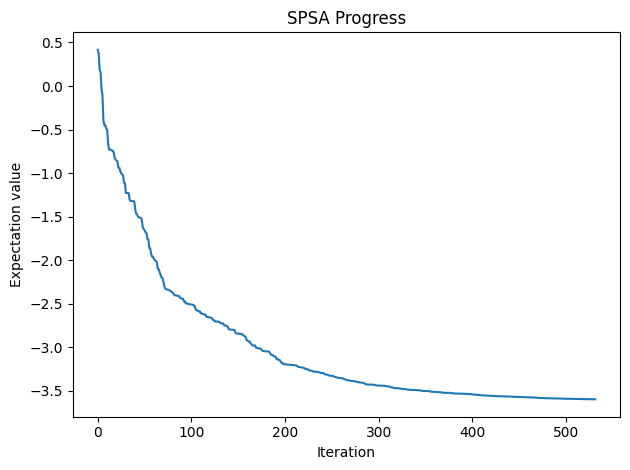

In [117]:
plt.plot(f_history)
plt.xlabel('Iteration')
plt.ylabel('Expectation value')
plt.title('SPSA Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [9]:
#Optimising using L-BFGS algorithm
def lbfgs(f, grad_f, x0, m=100, tol=1e-6, max_iter=1000):
    x = x0.copy()
    k = 0  # iteration counter
    s_list = []   
    y_list = []   
    rho_list = [] 
    g = grad_f(x)
    f_histry = []
    BOUND = 0  # number of updates used
    while np.linalg.norm(g) > tol and k < max_iter:
        q = g.copy()
        alpha = []
        if k < m:
            INCR = 0
            BOUND = k
        else:
            INCR = k - m
            BOUND = m
        for i in range(BOUND - 1, -1, -1):
            j = i + INCR
            if j >= len(s_list):  # safety check
                continue
            s = s_list[j]
            y = y_list[j]
            rho = rho_list[j]
            alpha_i = rho * np.dot(s, q)
            alpha.append(alpha_i)
            q = q - alpha_i * y

        alpha = alpha[::-1]  # to use in forward loop later

        if len(y_list) > 0:
            y_last = y_list[-1]
            s_last = s_list[-1]
            gamma = np.dot(s_last, y_last) / np.dot(y_last, y_last)
        else:
            gamma = 1.0
        r = gamma * q
        for i in range(0, BOUND):
            j = i + INCR
            if j >= len(s_list):  # safety check
                continue
            s = s_list[j]
            y = y_list[j]
            rho = rho_list[j]
            beta = rho * np.dot(y, r)
            r = r + s * (alpha[i] - beta)

        #search direction and backtracking line search
        p = -r
        t = 1.0
        while f(x + t * p) > f(x) + 1e-4 * t * np.dot(g, p):
            t *= 0.5
            if t < 1e-10:
                break
        #position and gradient update
        x_new = x + t * p
        g_new = grad_f(x_new)
        s_k = x_new - x
        y_k = g_new - g

        #store s_k, y_k, and ρ_k if curvature condition satisfied
        if np.dot(s_k, y_k) > 1e-10:
            s_list.append(s_k)
            y_list.append(y_k)
            rho_list.append(1.0 / np.dot(y_k, s_k))

            #maintaining memory size
            if len(s_list) > m:
                s_list.pop(0)
                y_list.pop(0)
                rho_list.pop(0)

        x = x_new
        g = g_new
        k += 1
        f_histry.append(f(x))
        #print(f"Iter {k:2d} | f(x) = {f(x):.6f} | ||grad|| = {np.linalg.norm(g):.2e}") 
    return x, f(x), k , f_histry


In [10]:
#writing a function grad that calculates gradient numerically 
def grad_numerical(func, v, h=1e-3):
    grad = np.zeros_like(v)
    for i in range(len(v)):
        v_plus = np.copy(v)
        v_minus = np.copy(v)
        v_plus[i] += h
        v_minus[i] -= h
        grad[i] = (func(v_plus) - func(v_minus)) / (2 * h)
    return grad

In [11]:
x0 =np.random.uniform(0, 2 * np.pi, pdim)  # Initial guess
solbfgs,fvalue,niter ,fhist= lbfgs(cost , lambda x: grad_numerical(cost, x), x0)
print("[L-BFGS] Optimal θ: ",solbfgs) 
print("[L-BFGS] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: ",fvalue)
print("[L-BFGS] Iterations:", niter)
print(fhist)

[L-BFGS] Optimal θ:  [ 6.28318538e+00  5.40132121e+00  3.14159494e+00  2.21776408e+00
  3.14159245e+00  3.28912682e+00  1.57079436e+00  1.57079646e+00
  1.57079628e+00  4.19727169e+00  7.91193412e-08  8.81863294e-01
 -1.83626102e-06 -9.23828448e-01  9.42477740e+00  2.99405849e+00
  1.57079430e+00  4.71238903e+00  1.57079625e+00  4.19727166e+00]
[L-BFGS] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:  -3.659610169033257
[L-BFGS] Iterations: 44
[-1.1897780603299384, -1.8938137374838644, -2.133351208909541, -2.314331115981336, -2.427261811602724, -2.627127539345576, -2.7356811382291344, -2.9388236326481527, -3.1328055276021103, -3.183391472586218, -3.2747596573495663, -3.4050615650857337, -3.5304602066838826, -3.5896487658259795, -3.64640955862764, -3.650644562290895, -3.65230142932763, -3.6542321271181515, -3.6568541341831584, -3.657353906109461, -3.6580042038569403, -3.658128461103379, -3.65849480853012, -3.6588660743527424, -3.6590955377175036, -3.6592848792252353, -3.659386503754072, -3.659545852775702

In [33]:
solbfgs= [ 6.28318538e+00,  5.40132121e+00  ,3.14159494e+00  ,2.21776408e+00,
  3.14159245e+00  ,3.28912682e+00 , 1.57079436e+00  ,1.57079646e+00,
  1.57079628e+00,  4.19727169e+00 , 7.91193412e-08 , 8.81863294e-01,
 -1.83626102e-06, -9.23828448e-01 , 9.42477740e+00 , 2.99405849e+00,
  1.57079430e+00,  4.71238903e+00 , 1.57079625e+00 , 4.19727166e+00]

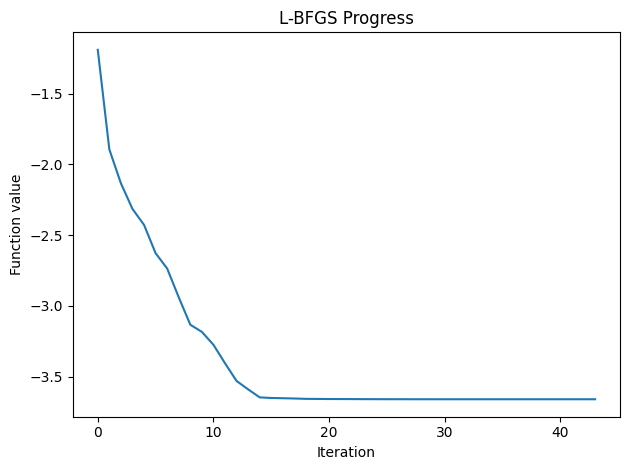

In [12]:
plt.plot(fhist)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('L-BFGS Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [13]:
#Optimizing using Adam algorithm
def adam_optimize(func, grad, theta_init, alpha=0.3, beta1=0.9, beta2=0.999,epsilon=1e-8, max_iters=500, tolerance=1e-6):
    theta = theta_init.copy()
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)

    thetas = [theta.copy()]
    losses = [func(theta)]
    f_history = []
    for t in range(1, max_iters + 1):
        g = grad_numerical(func, theta)

        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        theta = theta - alpha * m_hat / (np.sqrt(v_hat) + epsilon)

        f_val = func(theta)
        thetas.append(theta.copy())
        losses.append(f_val)
        f_history.append(f_val)
        # Early stopping based on function change
        if abs(losses[-1] - losses[-2]) < tolerance:
                #print(f"[Adam] Early stopping at iteration {t}: Δf = {abs(losses[-1] - losses[-2]):.2e} < {tolerance}")
                break

    return theta, losses, thetas, f_history


In [14]:

theta_init = np.random.uniform(0, 2 * np.pi, n_qubits*n_layers)  # Initial guess for θ
soladam, loss_history, theta_path,fhistory = adam_optimize(cost, lambda x: grad_numerical(cost, x), theta_init)
print(f"[Adam] Optimal θ: {soladam}")
print(f"[Adam] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: {loss_history[-1]:.6f}") 
print(f"[Adam] Iterations: {len(loss_history)}")
print(fhistory)

[Adam] Optimal θ: [ 6.14020932  3.66079031  1.57129062  4.71246094  7.055983    3.49535525
  4.71272311  1.57066089  4.71246946  1.57102186  6.42613591  3.67658207
  4.71259376  7.85311601 -0.77296274  3.49527094  1.57049471  1.57085329
  4.71230302  1.57059657]
[Adam] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: -3.659597
[Adam] Iterations: 157
[-0.8317983548220286, -1.4556477034537398, -1.9429068789520565, -2.2319716651715824, -2.4133230718113046, -2.6072731624335077, -2.7920280059589166, -2.9276450200596194, -2.9977914637760077, -3.0028854076486113, -2.949527348784844, -2.8944498253642026, -2.8917690988311477, -2.9218506783915834, -2.952462171968097, -2.989013129556784, -3.032450825525401, -3.0570899307888957, -3.062145135146252, -3.0777748678294743, -3.112179449843632, -3.150028000711253, -3.17918455688636, -3.1964312763998644, -3.212935402680302, -3.246964879142761, -3.2943781995010917, -3.3347181104629295, -3.3571696923860386, -3.375618328592264, -3.405934632893744, -3.4302583829868056, -3.42638

In [11]:
soladam=[ 6.14020932  ,3.66079031 , 1.57129062 , 4.71246094  ,7.055983   , 3.49535525,
  4.71272311 , 1.57066089  ,4.71246946 , 1.57102186 , 6.42613591 , 3.67658207,
  4.71259376 , 7.85311601 ,-0.77296274 , 3.49527094  ,1.57049471,  1.57085329,
  4.71230302 , 1.57059657]

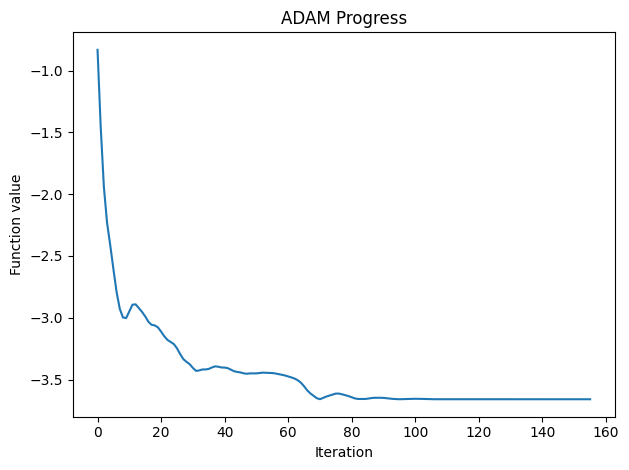

In [25]:
plt.plot(fhistory)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('ADAM Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

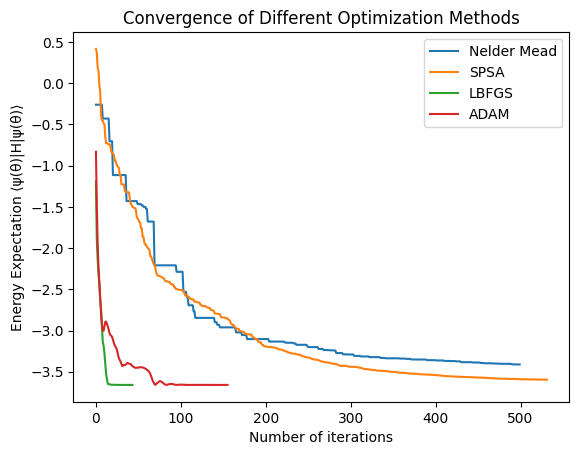

In [118]:
import matplotlib.pyplot as plt

y1 = fhisto
y2 = f_history
y3 = fhist
y4 = fhistory

# Generate corresponding x-values automatically
x1 = list(range(len(y1)))
x2 = list(range(len(y2)))
x3 = list(range(len(y3)))
x4 = list(range(len(y4)))

# Plot each with its own x
plt.plot(x1, y1, label='Nelder Mead')
plt.plot(x2, y2, label='SPSA')
plt.plot(x3, y3, label='LBFGS')
plt.plot(x4, y4, label='ADAM')

plt.xlabel('Number of iterations')
plt.ylabel('Energy Expectation ⟨ψ(θ)|H|ψ(θ)⟩')
plt.title('Convergence of Different Optimization Methods')
plt.legend()
plt.grid(False)
plt.show()



In [64]:
def sample_bitstrings(statevector, n_samples):
    probs = np.abs(statevector) ** 2
    assert np.isclose(np.sum(probs), 1.0), "Probabilities must sum to 1"
    outcomes = np.random.choice(len(probs), size=n_samples, p=probs) 
    bitstrings = [format(i, f'0{n_qubits}b') for i in outcomes]
    return bitstrings
theta = solnm  # example parameters
state = ansatz(theta, n_qubits, edges, n_layers)
bitstrings = sample_bitstrings(state , 1000)
print(bitstrings)
print("Sampled bitstrings:", len(bitstrings))


['1000110100', '1010110010', '1000110100', '1000110100', '1000110010', '1000110010', '1000110010', '1000110100', '1000110100', '1000110100', '1000100100', '1100110000', '1000110100', '1000110010', '1000110010', '1000110010', '1000110100', '1000110100', '1000110100', '1000110100', '1000110100', '1000110010', '1000110100', '1000110100', '1000110100', '1000110100', '1000110010', '1000110100', '1000110100', '1000110010', '1000110100', '1000110010', '1000110010', '1001110010', '1100110000', '1000110100', '1000110100', '1000110010', '1000110100', '1000110100', '1000110010', '1000110100', '1000110010', '1001110010', '1000110010', '1000110100', '1000110100', '1000110100', '1000110100', '1000110010', '1100110000', '1000110100', '1001110010', '1001110010', '1000110100', '1001110010', '1000110010', '1000110010', '1000110010', '1000110100', '1000110100', '1000110010', '1000110100', '1000110100', '1000110010', '1000110100', '1000110010', '1000110100', '1000110010', '1101110000', '1000110100', '1000

In [65]:
def hamiltonian(n_qubits, seed):
    np.random.seed(seed)
    # Build symbolic Hamiltonian: (weight, [i, j]) for ZZ terms
    weights2 = [round(x, 3) for x in weights]
    hamiltonian_terms = [(weights[k], [i, j]) for k, (i, j) in enumerate(edges)]
    return hamiltonian_terms
hamiltonian_terms=hamiltonian(n_qubits, seed) 

In [66]:
def estimate_expectation(bitstrings, hamiltonian_terms):
    total = 0
    for bitstring in bitstrings:
        val = 0
        for coeff, qubits in hamiltonian_terms:
            product = 1
            for q in qubits:
                product *= 1 if bitstring[q] == '0' else -1  # Z|0>=+1, Z|1>=-1
            val += coeff * product
        total += val
    return total / len(bitstrings)
expect_val = estimate_expectation(bitstrings, hamiltonian_terms)
print("Estimated ⟨H⟩ =", expect_val)
def bitstring_energy(bitstring, hamiltonian_terms):
    val = 0
    for coeff, qubits in hamiltonian_terms:
        product = 1
        for q in qubits:
            product *= 1 if bitstring[q] == '0' else -1  # Z|0>=+1, Z|1>=-1
        val += coeff * product
    return val

Estimated ⟨H⟩ = -3.2804680119566787


In [67]:
from collections import Counter
bitstring_counts = Counter(bitstrings)
bitstring_data = []
for bitstring, count in bitstring_counts.items():
    energy = bitstring_energy(bitstring, hamiltonian_terms)
    bitstring_data.append((bitstring, count, energy))
print(bitstring_data)

[('1000110100', 557, -3.4566089876880817), ('1010110010', 1, -3.0017463787296945), ('1000110010', 273, -3.1617489278669364), ('1000100100', 11, -2.183612094225629), ('1100110000', 21, -3.659610169033459), ('1001110010', 85, -3.1409486794639503), ('1101110000', 10, -3.638809920630472), ('1000010011', 3, -2.6920485932650973), ('1001010011', 2, -2.671248344862111), ('1000010101', 10, -2.9869086530862425), ('1100110110', 4, -0.16088540860054712), ('1000100010', 3, -3.1251319557015256), ('1010110100', 2, -3.2966064385508393), ('1011110010', 1, -0.7441657682538199), ('1000101000', 3, -1.466765464712151), ('1010010101', 1, -2.826906103949), ('1100111110', 1, 2.5930567601854744), ('1000110110', 3, -1.3353012015349144), ('1001110100', 2, -2.5864059529751695), ('1101010001', 1, -3.169109586028633), ('1101110110', 1, 0.7093176261123653), ('1000110000', 1, -2.4851943760990913), ('1001101000', 1, -1.4459652163091645), ('1000110011', 1, -1.5707105791732463), ('1000101110', 1, 0.14564407378865452), (

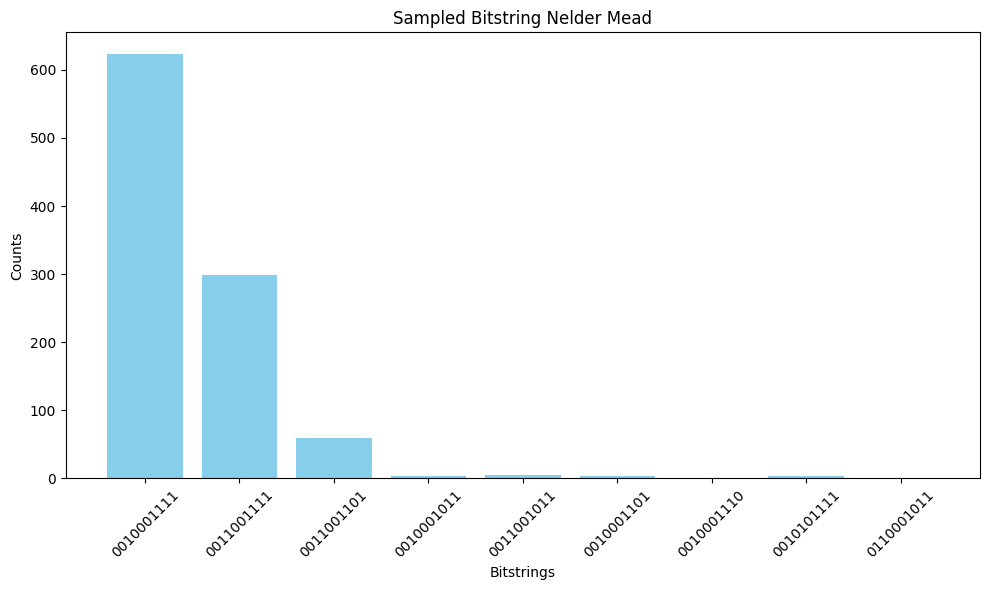

In [62]:
bitstrings_unique = list(bitstring_counts.keys())
frequencies = list(bitstring_counts.values())
plt.figure(figsize=(10,6))
plt.bar(bitstrings_unique, frequencies, color='skyblue')
plt.xlabel('Bitstrings')
plt.ylabel('Counts')
plt.title('Sampled Bitstring Nelder Mead')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
